In [1]:
import torch
import torchaudio
from torchaudio.datasets import LIBRISPEECH
import matplotlib.pyplot as plt

In [2]:
SPLITS = [
    "dev-clean",
    "train-clean-360",
]

DATA_ROOT = "/opt/data/private/linkdom/data/"

dataset = LIBRISPEECH(root = DATA_ROOT, url = SPLITS[0], download = False)

In [3]:
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in dataset:
    print(waveform.shape, sample_rate, utterance.lower(), f"{speaker_id}-{chapter_id}-{utterance_id}")
    break

torch.Size([1, 93680]) 16000 mister quilter is the apostle of the middle classes and we are glad to welcome his gospel 1272-128104-0


## extract features--kaldi

In [4]:
# config
num_ceps = 13
num_mel_bins = 80
frame_length = 25 
frame_shift = 10

In [5]:
feature_mfcc = torchaudio.compliance.kaldi.mfcc(
    waveform=waveform, 
    num_ceps=num_ceps, 
    sample_frequency=sample_rate, 
    frame_length=frame_length, 
    frame_shift=frame_shift
)

feature_mfcc = feature_mfcc.unsqueeze(0).transpose(1, 2)
d1 = torchaudio.functional.compute_deltas(feature_mfcc)
d2 = torchaudio.functional.compute_deltas(d1)
feature_mfcc = torch.cat([feature_mfcc, d1, d2], dim=1)
feature_mfcc = feature_mfcc.transpose(1, 2).squeeze(0)

feature_fbank = torchaudio.compliance.kaldi.fbank(
    waveform=waveform, 
    num_mel_bins=num_mel_bins, 
    sample_frequency=sample_rate, 
    frame_length=frame_length, 
    frame_shift=frame_shift
)

def cmvn(feature, eps=1e-10):
    mean = feature.mean(dim=0, keepdim=True)
    std = feature.std(dim=0, keepdim=True)
    return (feature - mean) / (std + eps)

feature_mfcc = cmvn(feature_mfcc)
feature_fbank = cmvn(feature_fbank)

print(feature_mfcc.shape, feature_fbank.shape)

torch.Size([584, 39]) torch.Size([584, 80])


## show features

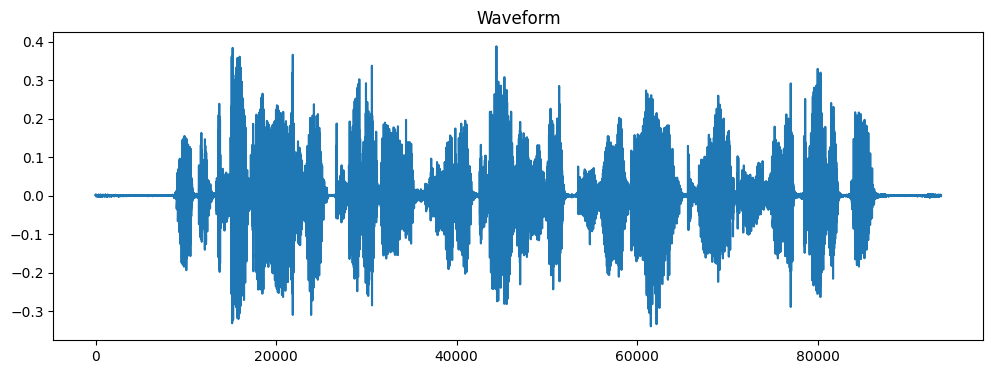

In [6]:
# plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.show()

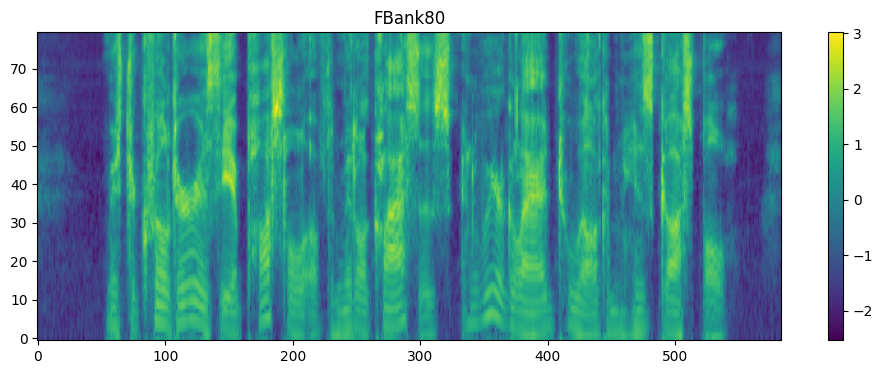

In [7]:
# plot the fbank features
plt.figure(figsize=(12, 4))
plt.imshow(feature_fbank.t().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'FBank{num_mel_bins}')
plt.show()


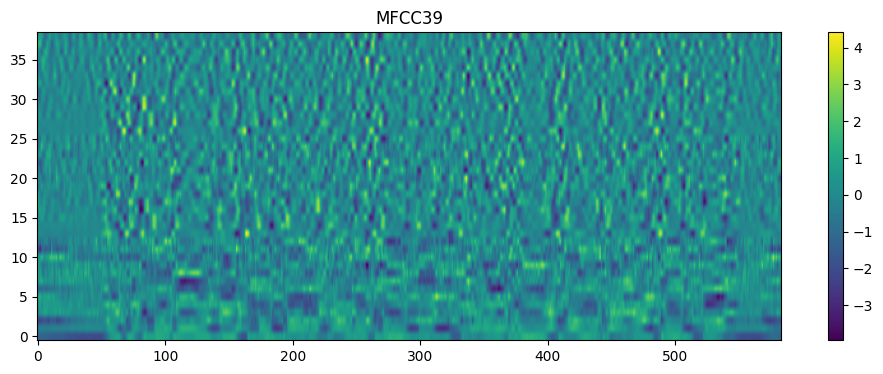

In [8]:
# 绘制MFCC图
plt.figure(figsize=(12, 4))
plt.imshow(feature_mfcc.t().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'MFCC{3 * num_ceps}')
plt.show()

In [9]:
feature_fbank[:2, :5], feature_mfcc[:2, :5]

(tensor([[-1.7424, -1.5811, -1.3875, -1.4973, -1.5812],
         [-1.7358, -1.5583, -1.5648, -1.7188, -1.7981]]),
 tensor([[-1.3018, -0.3810, -2.1658, -0.1347, -0.0764],
         [-1.2475, -0.4270, -2.4043,  0.0830,  0.5629]]))